# Trabajo práctico N° 3: Computer Vision

### Integrantes
<ul>
    <li>Aguilar, Agustín</li>
    <li>Ferrari, Nicolás</li>
    <li>Sosa, Emiliano</li>
</ul>

### Propósito
Crear un modelo que sea capaz de, a partir de una imagen, predecir que tipo de fruta es. Nuestro modelo sabrá reconocer 64 tipos de frutas distintas

### Imports & libs

In [3]:
import os
from zipfile import ZipFile

import numpy as np
import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten

from utils import download_file_from_google_drive

%matplotlib inline

### Funciones útiles
Cosas útiles a utilizar a lo largo de la resolución del problema

In [4]:
PICTURE_SIZE = 50
CHANNELS = 'rgb'

INPUT_COLUMNS = []

for color in CHANNELS:
    INPUT_COLUMNS.extend(['%s%i' % (color, i)
                          for i in range(PICTURE_SIZE ** 2)])

In [5]:
def extract_inputs(dataset, cnn):
    if cnn: 
        return dataset[INPUT_COLUMNS].values.reshape(len(dataset), PICTURE_SIZE, PICTURE_SIZE, len(CHANNELS)) / 255
    return dataset[INPUT_COLUMNS].values / 255
    

def extract_outputs(dataset):
    is_fruit_columns = [(dataset.type_fruit == fruit).values for fruit in FRUITS_TYPES]
    return np.array(is_fruit_columns).T

In [6]:
def show_images(samples, title='file_name'):
    for index, sample in samples.iterrows():
        if title is not None:
            if isinstance(title, str):
                title = [title, ]
            title_text = ', '.join(str(sample[title_field]) for title_field in title)
            plt.title(title_text)

        sample_as_grid = sample[INPUT_COLUMNS].values.reshape(len(CHANNELS), PICTURE_SIZE, PICTURE_SIZE).astype(np.float)
        sample_as_grid = np.transpose(sample_as_grid, (1, 2, 0)) / 255
        
        plt.axis('off')
        plt.imshow(sample_as_grid, interpolation='nearest')

        plt.show()

In [7]:
def add_predictions(dataset, have_label, cnn=False):
    predictions = model.predict(extract_inputs(dataset, cnn))

    for fruit_number, fruit in enumerate(FRUITS_TYPES):
        dataset[fruit] = predictions[:, fruit_number]
    
    dataset['prediction'] = dataset[FRUITS_TYPES].idxmax(axis=1)
    dataset['prediction_confidence'] = dataset[FRUITS_TYPES].max(axis=1)
    if have_label:
        dataset['correct'] = dataset.prediction == dataset.type_fruit
    print(classification_report(
        y_pred=np.array(dataset[FRUITS_TYPES].idxmax(axis=1)), 
        y_true=np.array(dataset.type_fruit)
    ))

### Datos
Vamos a descargar el .zip que contiene las imágenes y luego vamos transformarlas en un DataFrame de Pandas 

In [8]:
try:
    df = pd.read_csv("data/fruits_360.csv")
except:
    print("Descargando csv de datos...")
    download_file_from_google_drive("1ueWViSdqlJvQOvCWp-LB9vnuvoviNfvN", "data/fruits_360.csv")
    df = pd.read_csv("data/fruits_360.csv")

Descargando csv de datos...


In [9]:
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [10]:
df.head()

,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,b2493,b2494,b2495,b2496,b2497,b2498,b2499,label,type_fruit,file_name
0,253,255,255,251,252,255,255,255,252,248,...,255,255,255,255,255,255,255,44,Apple Red 2,208_100.jpg
1,255,254,253,254,255,255,255,253,254,255,...,255,255,255,255,255,255,255,44,Apple Red 2,300_100.jpg
2,255,255,253,251,252,254,254,252,250,253,...,255,255,255,255,255,255,255,44,Apple Red 2,r_103_100.jpg
3,252,250,250,252,255,255,255,255,254,254,...,255,255,255,255,255,255,255,44,Apple Red 2,312_100.jpg
4,255,255,254,252,254,253,253,253,253,253,...,255,255,255,255,255,255,255,44,Apple Red 2,288_100.jpg


#### Datos de entrada
Los datos de entrada a nuestros modelos van a ser la información de color por pixel de la imagen. Es decir, que cantidad de rojo (R) contiene el pixel X, que cantidad de verde (G) contiene el pixel X y que cantidad de azul (B) contiene el pixel X. Dicho esto, para una imágen tendremos 7500 columnas dado que nuestras imágenes serán de 50x50. Un ejemplo:

In [9]:
df.sample(1)[INPUT_COLUMNS]

,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,b2490,b2491,b2492,b2493,b2494,b2495,b2496,b2497,b2498,b2499
20253,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


#### Datos de salida
Los datos de salida de nuestra red van a dar respuesta a la probabilidad que esa imagen pertenezca a cada una de las clases o tipos de frutas en cuestión.
Estos tipos son:

In [10]:
FRUITS_TYPES = df.type_fruit.unique()
FRUITS_TYPES

array(['Apple Red 2', 'Apple Golden 2', 'Kumquats', 'Nectarine',
       'Maracuja', 'Apple Red Yellow', 'Grape White', 'Tangelo',
       'Pear Williams', 'Pitahaya Red', 'Cherry 2', 'Apple Red 3', 'Pear',
       'Salak', 'Cactus fruit', 'Peach Flat', 'Cantaloupe 1', 'Kaki',
       'Pear Abate', 'Strawberry', 'Guava', 'Plum', 'Pomegranate',
       'Apple Red Delicious', 'Apple Golden 1', 'Pear Monster',
       'Cherry 1', 'Apple Braeburn', 'Pineapple', 'Grapefruit White',
       'Clementine', 'Mango', 'Cantaloupe 2', 'Pepino', 'Peach', 'Kiwi',
       'Orange', 'Tamarillo', 'Avocado ripe', 'Grapefruit Pink', 'Cocos',
       'Apricot', 'Apple Golden 3', 'Cherry Rainier', 'Dates',
       'Passion Fruit', 'Papaya', 'Grape White 2', 'Apple Red 1', 'Lemon',
       'Grape Pink', 'Carambula', 'Lemon Meyer', 'Banana Red', 'Banana',
       'Apple Granny Smith', 'Quince', 'Huckleberry', 'Raspberry',
       'Mandarine', 'Avocado', 'Limes', 'Litchi', 'Granadilla'],
      dtype=object)

### Algunas imágenes

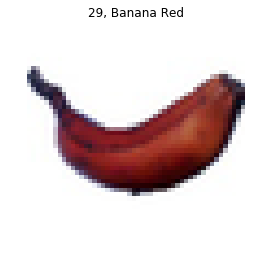

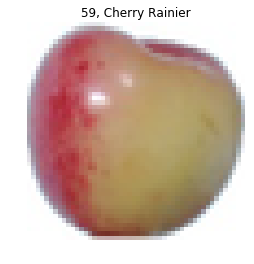

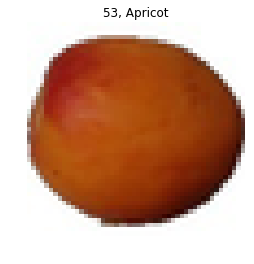

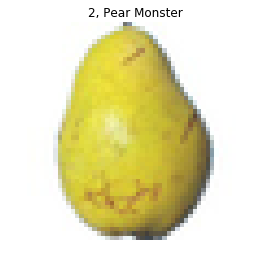

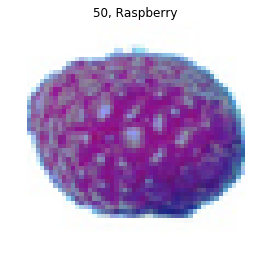

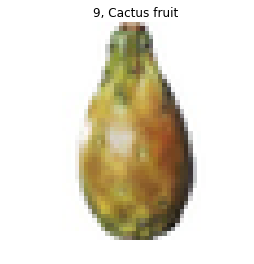

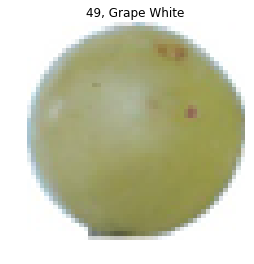

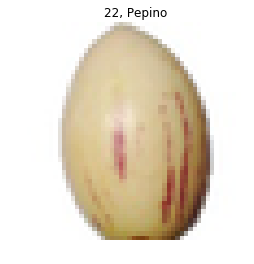

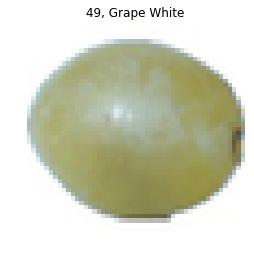

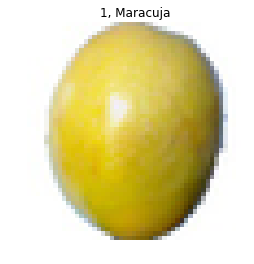

In [11]:
show_images(df.sample(10), ["label", "type_fruit"])

## Dividimos nuestro dataset

Imagenes del set train
Dimensión de train: (27487, 7503)


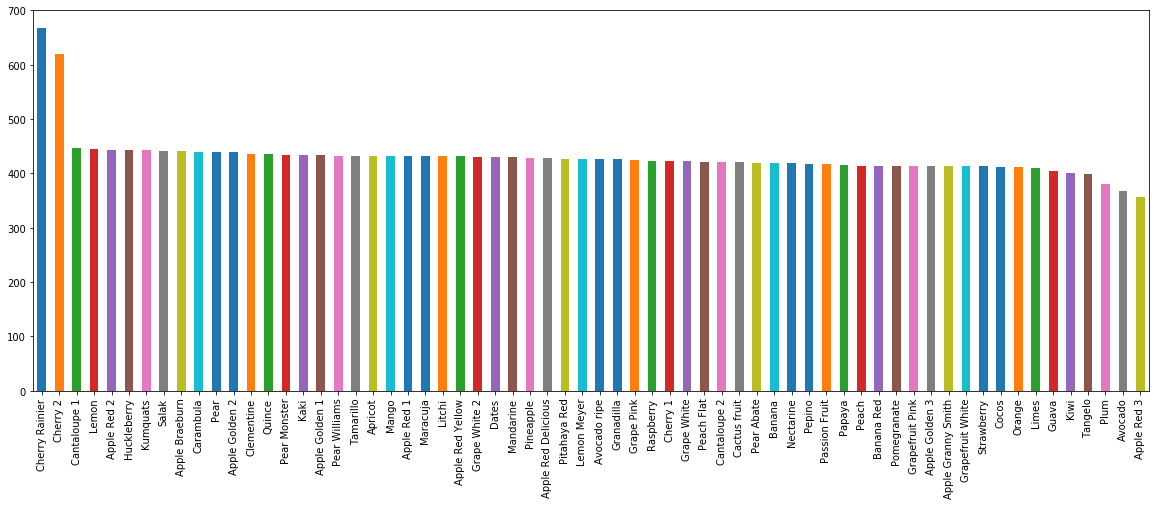

Imagenes del set test
Dimensión de test: (4124, 7503)


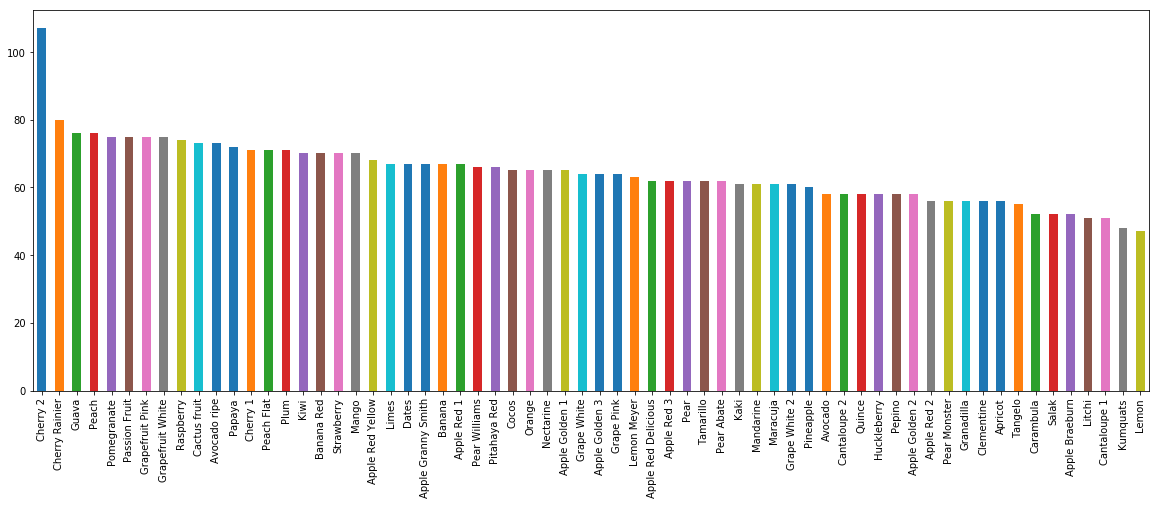

Imagenes del set validation
Dimensión de validation: (2748, 7503)


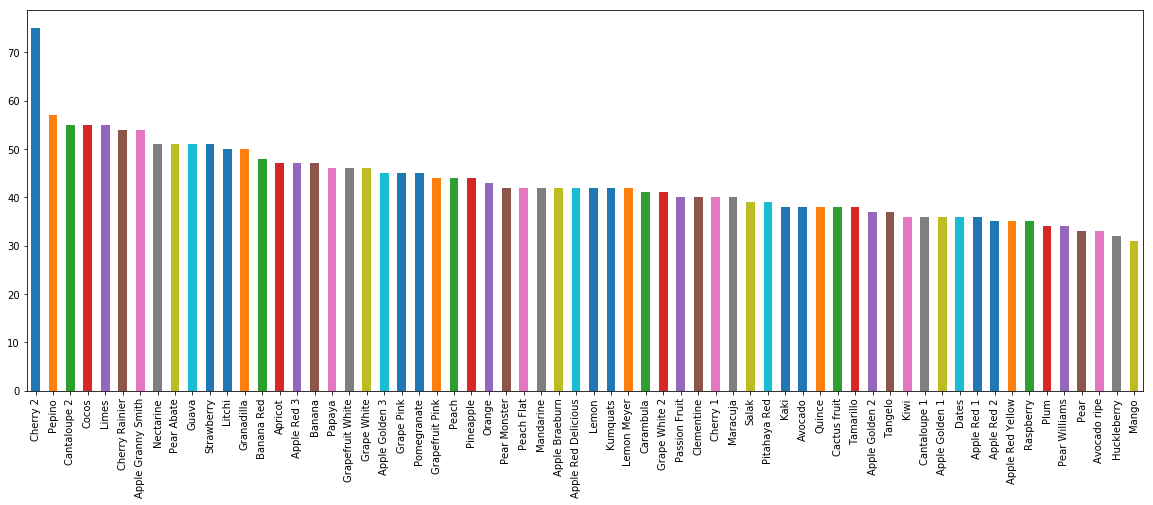

In [12]:
train, test_validation = train_test_split(df, test_size=0.2)
validation, test = train_test_split(test_validation, test_size=0.6)
sets = (
    ('train', train),
    ('test', test),
    ('validation', validation)
)

for set_name, set_data in sets:
    print("Imagenes del set", set_name)
    print("Dimensión de {setname}: {dim}".format(
        setname=set_name,
        dim=set_data.shape
    ))
    set_data.type_fruit.value_counts().plot.bar(figsize=(20,7))
    plt.show()

### Red neuronal

In [13]:
model = Sequential ([
    Dense(16, activation="relu", input_shape =(PICTURE_SIZE**2*len(CHANNELS),),init='glorot_uniform'),
    Dense(256, activation="tanh", init='glorot_uniform'),
    Dense(128, activation="relu", init='glorot_uniform'),
    Dense(32, activation="tanh", init='glorot_uniform'),
    Dense(64, activation="softmax", init='glorot_uniform'),
])
    
model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                120016    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               4352      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
Total params: 163,504
Trainable params: 163,504
Non-trainable params: 0
_________________________________________________________________


/home/lenovo2/Documentos/dev/ml/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, input_shape=(7500,), activation="relu", kernel_initializer="glorot_uniform")`
  
/home/lenovo2/Documentos/dev/ml/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="tanh", kernel_initializer="glorot_uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/lenovo2/Documentos/dev/ml/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="glorot_uniform")`
  after removing the cwd from sys.path.
/home/lenovo2/Documentos/dev/ml/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="tanh", kernel_initializer="gl

In [14]:
history = model.fit(
    extract_inputs(train, cnn=False), 
    extract_outputs(train), 
    epochs=5,
    batch_size=128,
    validation_data=(
        extract_inputs(test, cnn=False),
        extract_outputs(test),
    )
)

Train on 27487 samples, validate on 4124 samples
Epoch 1/5
27487/27487 [==============================] - 9s 337us/step - loss: 2.4929 - acc: 0.4585 - val_loss: 1.4206 - val_acc: 0.7493
Epoch 2/5
27487/27487 [==============================] - 9s 324us/step - loss: 0.9661 - acc: 0.8307 - val_loss: 0.6426 - val_acc: 0.8894
Epoch 3/5
27487/27487 [==============================] - 9s 322us/step - loss: 0.4822 - acc: 0.9179 - val_loss: 0.3450 - val_acc: 0.9452
Epoch 4/5
27487/27487 [==============================] - 9s 324us/step - loss: 0.2714 - acc: 0.9597 - val_loss: 0.2179 - val_acc: 0.9661
Epoch 5/5
27487/27487 [==============================] - 9s 325us/step - loss: 0.1693 - acc: 0.9747 - val_loss: 0.1359 - val_acc: 0.9779


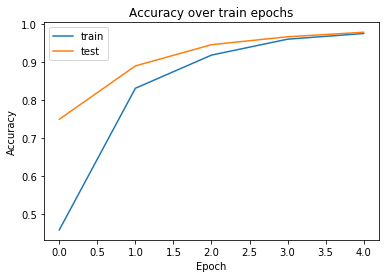

In [15]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

######################### train #########################


/home/lenovo2/Documentos/dev/ml/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/lenovo2/Documentos/dev/ml/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/lenovo2/Documentos/dev/ml/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

                     precision    recall  f1-score   support

     Apple Braeburn       0.94      1.00      0.97       440
     Apple Golden 1       0.97      1.00      0.98       433
     Apple Golden 2       0.95      1.00      0.98       439
     Apple Golden 3       1.00      1.00      1.00       413
 Apple Granny Smith       1.00      1.00      1.00       413
        Apple Red 1       1.00      1.00      1.00       431
        Apple Red 2       1.00      0.94      0.97       443
        Apple Red 3       1.00      1.00      1.00       357
Apple Red Delicious       1.00      0.99      0.99       428
   Apple Red Yellow       1.00      1.00      1.00       431
            Apricot       1.00      1.00      1.00       431
            Avocado       1.00      1.00      1.00       368
       Avocado ripe       1.00      1.00      1.00       427
             Banana       1.00      0.94      0.97       418
         Banana Red       1.00      0.96      0.98       414
       Cactus fruit    

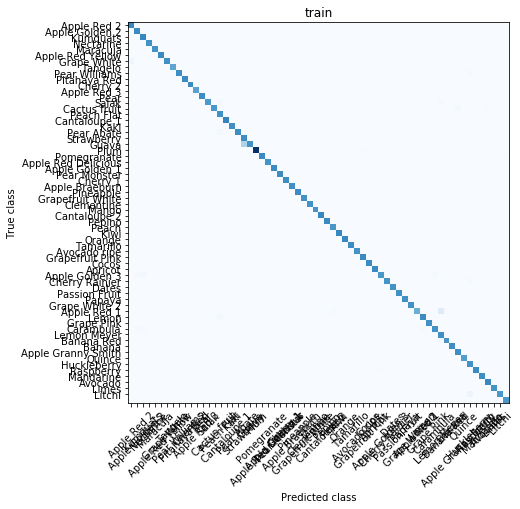

######################### test #########################
                     precision    recall  f1-score   support

     Apple Braeburn       0.90      1.00      0.95        52
     Apple Golden 1       0.98      1.00      0.99        65
     Apple Golden 2       0.97      1.00      0.98        58
     Apple Golden 3       1.00      1.00      1.00        64
 Apple Granny Smith       0.99      0.99      0.99        67
        Apple Red 1       1.00      1.00      1.00        67
        Apple Red 2       1.00      0.89      0.94        56
        Apple Red 3       1.00      1.00      1.00        62
Apple Red Delicious       1.00      1.00      1.00        62
   Apple Red Yellow       1.00      1.00      1.00        68
            Apricot       1.00      1.00      1.00        56
            Avocado       1.00      1.00      1.00        58
       Avocado ripe       1.00      1.00      1.00        73
             Banana       1.00      0.94      0.97        67
         Banana Red       1

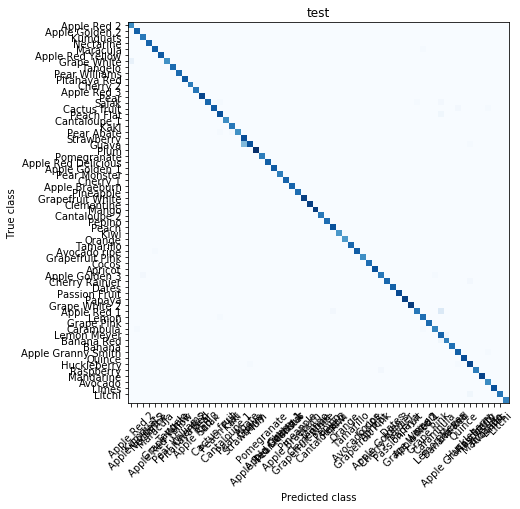

######################### validation #########################
                     precision    recall  f1-score   support

     Apple Braeburn       0.98      1.00      0.99        42
     Apple Golden 1       0.97      1.00      0.99        36
     Apple Golden 2       1.00      1.00      1.00        37
     Apple Golden 3       1.00      1.00      1.00        45
 Apple Granny Smith       0.96      1.00      0.98        54
        Apple Red 1       1.00      1.00      1.00        36
        Apple Red 2       1.00      0.97      0.99        35
        Apple Red 3       1.00      1.00      1.00        47
Apple Red Delicious       1.00      1.00      1.00        42
   Apple Red Yellow       1.00      1.00      1.00        35
            Apricot       1.00      1.00      1.00        47
            Avocado       1.00      1.00      1.00        38
       Avocado ripe       1.00      1.00      1.00        33
             Banana       1.00      1.00      1.00        47
         Banana Red  

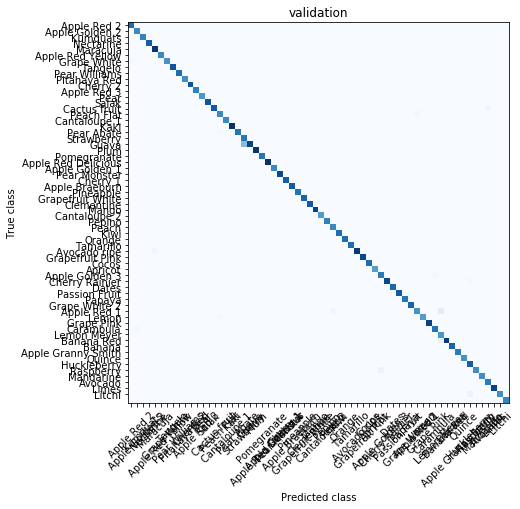

In [16]:
for set_name, set_data in sets:
    print('#' * 25, set_name, '#' * 25)

    add_predictions(set_data, True, False)
    print('accuracy', accuracy_score(set_data.type_fruit, set_data.prediction))

    
    # plot confussion matrix
        
    plt.figure(figsize=(20,7))
        
    plt.xticks(list(range(63)), FRUITS_TYPES, rotation=45)
    plt.yticks(list(range(63)), FRUITS_TYPES)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

    plt.title(set_name)

    plt.imshow(
        confusion_matrix(set_data.type_fruit, set_data.prediction), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

### CNN

In [17]:
model = Sequential([
    #Dense(10, activation='tanh', input_shape=(len(INPUT_COLUMNS), )),
    Convolution2D(32, (4, 4), activation='relu', input_shape=(PICTURE_SIZE, PICTURE_SIZE, len(CHANNELS)),),
    Convolution2D(16, (4, 4), activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.5),
    Convolution2D(8, (3, 3), activation='tanh'),
    Flatten(),
        
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='tanh'),
    Dropout(0.2),
    Dense(64, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [18]:
history = model.fit(
    extract_inputs(train, cnn=True), 
    extract_outputs(train), 
    epochs=3,
    batch_size=128,
    validation_data=(
        extract_inputs(test, cnn=True),
        extract_outputs(test),
    )
)

Train on 27487 samples, validate on 4124 samples
Epoch 1/3
27487/27487 [==============================] - 203s 7ms/step - loss: 2.7938 - acc: 0.2833 - val_loss: 1.1407 - val_acc: 0.7136
Epoch 2/3
27487/27487 [==============================] - 202s 7ms/step - loss: 1.2013 - acc: 0.6648 - val_loss: 0.4518 - val_acc: 0.9127
Epoch 3/3
27487/27487 [==============================] - 201s 7ms/step - loss: 0.7581 - acc: 0.7883 - val_loss: 0.2329 - val_acc: 0.9600


#### Curva de aprendizaje

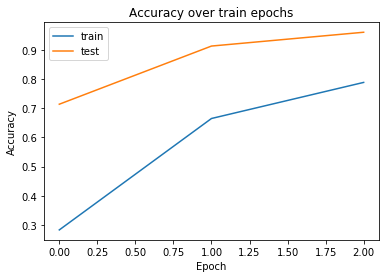

In [19]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

#### Matriz de confusión

######################### train #########################


/home/lenovo2/Documentos/dev/ml/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/lenovo2/Documentos/dev/ml/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/lenovo2/Documentos/dev/ml/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

                     precision    recall  f1-score   support

     Apple Braeburn       0.82      0.83      0.83       440
     Apple Golden 1       1.00      1.00      1.00       433
     Apple Golden 2       0.97      1.00      0.99       439
     Apple Golden 3       1.00      0.88      0.94       413
 Apple Granny Smith       0.88      1.00      0.93       413
        Apple Red 1       0.95      0.95      0.95       431
        Apple Red 2       0.96      0.98      0.97       443
        Apple Red 3       1.00      1.00      1.00       357
Apple Red Delicious       1.00      0.99      0.99       428
   Apple Red Yellow       0.98      1.00      0.99       431
            Apricot       1.00      0.99      0.99       431
            Avocado       1.00      1.00      1.00       368
       Avocado ripe       0.99      1.00      0.99       427
             Banana       0.98      1.00      0.99       418
         Banana Red       1.00      0.97      0.99       414
       Cactus fruit    

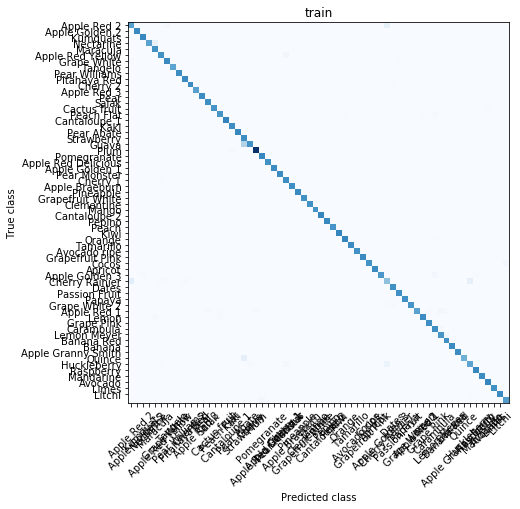

######################### test #########################
                     precision    recall  f1-score   support

     Apple Braeburn       0.81      0.75      0.78        52
     Apple Golden 1       1.00      0.98      0.99        65
     Apple Golden 2       0.95      1.00      0.97        58
     Apple Golden 3       1.00      0.89      0.94        64
 Apple Granny Smith       0.88      1.00      0.94        67
        Apple Red 1       0.91      0.93      0.92        67
        Apple Red 2       0.97      1.00      0.98        56
        Apple Red 3       1.00      1.00      1.00        62
Apple Red Delicious       1.00      1.00      1.00        62
   Apple Red Yellow       0.96      1.00      0.98        68
            Apricot       1.00      0.95      0.97        56
            Avocado       1.00      1.00      1.00        58
       Avocado ripe       1.00      1.00      1.00        73
             Banana       0.96      1.00      0.98        67
         Banana Red       1

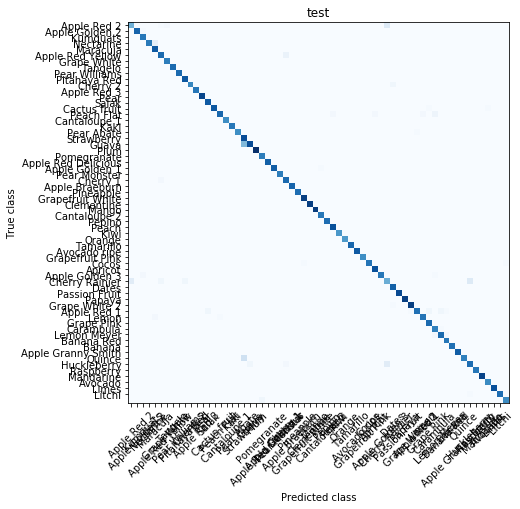

######################### validation #########################
                     precision    recall  f1-score   support

     Apple Braeburn       0.82      0.74      0.78        42
     Apple Golden 1       1.00      1.00      1.00        36
     Apple Golden 2       1.00      1.00      1.00        37
     Apple Golden 3       1.00      0.91      0.95        45
 Apple Granny Smith       0.93      1.00      0.96        54
        Apple Red 1       0.95      1.00      0.97        36
        Apple Red 2       0.89      0.97      0.93        35
        Apple Red 3       1.00      1.00      1.00        47
Apple Red Delicious       1.00      1.00      1.00        42
   Apple Red Yellow       0.90      1.00      0.95        35
            Apricot       1.00      1.00      1.00        47
            Avocado       1.00      1.00      1.00        38
       Avocado ripe       1.00      1.00      1.00        33
             Banana       1.00      1.00      1.00        47
         Banana Red  

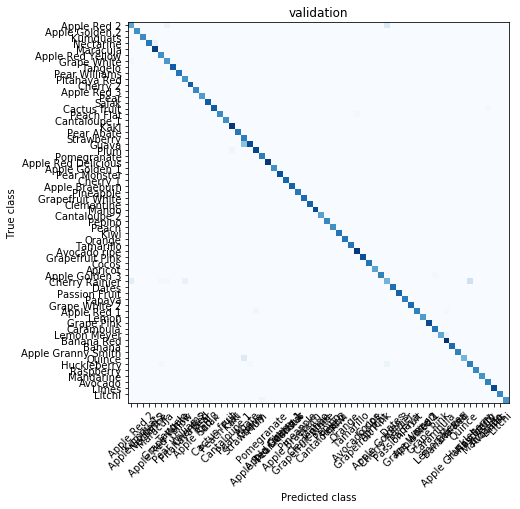

In [20]:
for set_name, set_data in sets:
    print('#' * 25, set_name, '#' * 25)

    add_predictions(set_data, True, True)
    print('accuracy', accuracy_score(set_data.type_fruit, set_data.prediction))

    
    # plot confussion matrix
        
    plt.figure(figsize=(20,7))
        
    plt.xticks(list(range(63)), FRUITS_TYPES, rotation=45)
    plt.yticks(list(range(63)), FRUITS_TYPES)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

    plt.title(set_name)

    plt.imshow(
        confusion_matrix(set_data.type_fruit, set_data.prediction), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()